In [49]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# VGG-19 modelini yüklüyoruz (Görseli analiz edecek olan beyin)
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

print("1. Adım Tamam: Kütüphaneler ve Model Hazır!")

1. Adım Tamam: Kütüphaneler ve Model Hazır!


In [50]:
def resmi_yukle_ve_hazirla(yol):
    # Dosyayı oku
    img = tf.io.read_file(yol)
    # PNG veya JPG fark etmeksizin piksellere ayır
    img = tf.image.decode_image(img, channels=3)
    # Sayıları 0-1 arasına çek (Normalizasyon)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Modelin hızlı çalışması için boyutu ayarla
    img = tf.image.resize(img, (512, 512))
    # Modele "bu 1 adet resimdir" diye fısılda (Batch dimension)
    return img[tf.newaxis, :]

print("2. Adım Tamam: Dönüştürücü Fonksiyon Hazır!")

2. Adım Tamam: Dönüştürücü Fonksiyon Hazır!


In [51]:
content_image = resmi_yukle_ve_hazirla('benimki.png')
style_image = resmi_yukle_ve_hazirla('van_gogh_tablosu.jpg')

print("3. Adım Tamam: Resimler başarıyla yüklendi!")

3. Adım Tamam: Resimler başarıyla yüklendi!


In [52]:
content_image = resmi_yukle_ve_hazirla('benimki.png')
style_image = resmi_yukle_ve_hazirla('van_gogh_tablosu.jpg')

print("3. Adım Tamam: Resimler başarıyla yüklendi!")

3. Adım Tamam: Resimler başarıyla yüklendi!


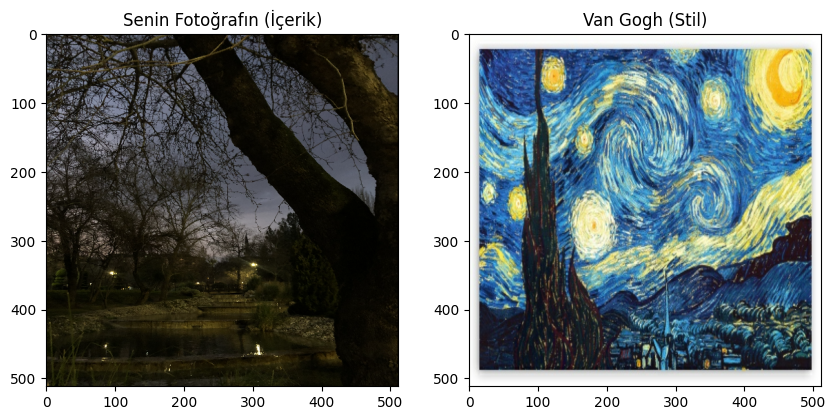

In [53]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(content_image))
plt.title('Senin Fotoğrafın (İçerik)')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(style_image))
plt.title('Van Gogh (Stil)')
plt.show()

In [54]:
# Stil ve içerik katmanlarını tanımlıyoruz
stil_katmanlari = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
icerik_katmanlari = ['block5_conv2']

def model_olustur(katmanlar):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in katmanlar]
    return tf.keras.Model([vgg.input], outputs)

ozellik_ozetleyici = model_olustur(stil_katmanlari + icerik_katmanlari)

In [55]:
def gram_matrix(input_tensor):
    # Matris çarpımı yaparak özelliklerin birbirleriyle ilişkisini buluyoruz
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

In [56]:
stil_cikti = ozellik_ozetleyici(style_image)
icerik_cikti = ozellik_ozetleyici(content_image)

# Stil hedefleri (Gram Matrix olarak)
stil_hedefleri = [gram_matrix(s) for s in stil_cikti[:len(stil_katmanlari)]]

# İçerik hedefi
icerik_hedefi = icerik_cikti[len(stil_katmanlari):]

print("Hedefler belirlendi! Bilgisayar artık neye benzemeye çalışacağını biliyor.")

Hedefler belirlendi! Bilgisayar artık neye benzemeye çalışacağını biliyor.


In [57]:
goruntu = tf.Variable(content_image)
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [58]:
stil_agirligi = 1e-1
icerik_agirligi = 1e3

def stil_icerik_kaybi(cikti):
    stil_ciktilari = cikti[:len(stil_katmanlari)]
    icerik_ciktilari = cikti[len(stil_katmanlari):]

    stil_kaybi = tf.add_n([tf.reduce_mean((gram_matrix(stil_ciktilari[i]) - stil_hedefleri[i])**2)
                           for i in range(len(stil_ciktilari))])

    icerik_kaybi = tf.add_n([tf.reduce_mean((icerik_ciktilari[i] - icerik_hedefi[i])**2)
                             for i in range(len(icerik_ciktilari))])

    return stil_kaybi * stil_agirligi + icerik_kaybi * icerik_agirligi
opt = tf.optimizers.Adam(learning_rate=0.03, beta_1=0.99, epsilon=1e-1)

In [59]:
@tf.function()
def egitim_adimi(goruntu):
    with tf.GradientTape() as tape:
        # 1. Resmin özelliklerini çıkar
        ciktilar = ozellik_ozetleyici(goruntu)
        # 2. Ne kadar hata yaptığını hesapla
        kayip = stil_icerik_kaybi(ciktilar)

    # 3. Hatayı düzeltmek için pikselleri hangi yöne kaydıracağını bul (Gradients)
    grad = tape.gradient(kayip, goruntu)
    # 4. Pikselleri güncelle
    opt.apply_gradients([(grad, goruntu)])
    # 5. Resmin renk değerlerinin 0 ile 1 arasında kalmasını sağla
    goruntu.assign(tf.clip_by_value(goruntu, clip_value_min=0.0, clip_value_max=1.0))

print("Boyacı robot hazır! Şimdi başlatma zamanı.")

Boyacı robot hazır! Şimdi başlatma zamanı.


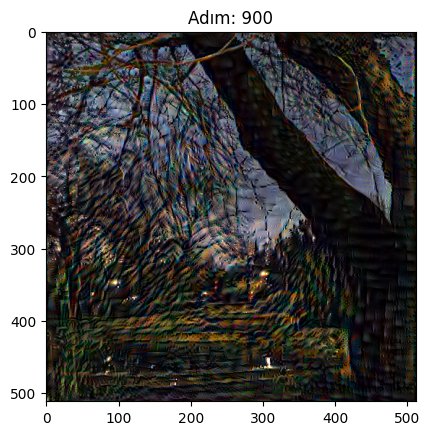

Sanat eseri hazır.


In [60]:
import IPython.display as display

for i in range(1000):
    egitim_adimi(goruntu)
    if i % 100 == 0:
        display.clear_output(wait=True)
        plt.imshow(np.squeeze(goruntu.read_value()))
        plt.title(f"Adım: {i}")
        plt.show()

print("Sanat eseri hazır.")